In [1]:
import numpy as np
import pandas as pd
import re
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

In [2]:
user_columns = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users_df = pd.read_csv('data/u_user.csv', sep='|', names=user_columns)
users_df.head(2)

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043


In [3]:
genre_df = pd.read_csv("data/u_genre.csv", sep='|', encoding='latin-1')
genre_columns = ["unknown"] + list(genre_df[genre_df.columns[0]].values)
print(genre_columns)

['unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [4]:
movie_columns = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies_df = pd.read_csv('data/u_item.csv', sep='|', names=movie_columns+genre_columns,
                     encoding='latin-1')
movies_df = movies_df[["movie_id", "title"]]
movies_df.head(2)

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)


In [5]:
ratings_columns = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings_df = pd.read_csv('data/u_data.csv', sep='\t', names=ratings_columns)
# ratings_df.drop( "unix_timestamp", inplace = True, axis = 1 ) 
ratings_df

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [ ]:
def split_train_test_by_user(df, user_col='user_id', time_col='unix_timestamp'):
    train_list = []
    test_list = []

    # Lấy danh sách 100 user_id cuối
    unique_users = df[user_col].unique()
    last_100_users = unique_users[-100:]  # 100 user cuối
    other_users = unique_users[:-100]  # Các user khác

    # Xử lý 100 người dùng cuối
    for user_id, user_data in df[df[user_col].isin(last_100_users)].groupby(user_col):
        # Sắp xếp dữ liệu của user theo thời gian
        user_data = user_data.sort_values(by=time_col)

        # Lấy 10 phim đầu tiên vào train
        train_list.append(user_data.iloc[:10])  # 10 phim đầu tiên

        # Lấy 10 phim tiếp theo sau 10 phim đầu tiên vào test
        test_list.append(user_data.iloc[10:20])  # 10 phim tiếp theo

    # Xử lý các user khác
    for user_id, user_data in df[df[user_col].isin(other_users)].groupby(user_col):
        # Toàn bộ dữ liệu vào train
        train_list.append(user_data)

        # Không có dữ liệu test cho user khác
        zero_test_data = user_data.copy()
        zero_test_data['rating'] = 0  # Gán rating = 0
        test_list.append(zero_test_data.iloc[0:0])  # Test rỗng cho các user khác

    # Kết hợp lại thành DataFrame
    train_df = pd.concat(train_list)
    test_df = pd.concat(test_list)

    # Loại bỏ cột unix_timestamp nếu cần
    train_df = train_df.drop(columns=[time_col], errors='ignore')
    test_df = test_df.drop(columns=[time_col], errors='ignore')

    return train_df, test_df


# Gọi hàm chia dữ liệu
train_df, test_df = split_train_test_by_user(ratings_df, user_col='user_id', time_col='unix_timestamp')

# Hiển thị kết quả
print("Train DataFrame:")
print(train_df.head())
print("Test DataFrame:")
print(test_df)


Train DataFrame:
       user_id  movie_id  rating
62813      820       315       3
98094      820       258       3
68219      822       272       3
60469      822       333       4
59433      824       286       2
Test DataFrame:
       user_id  movie_id  rating
96581      820       347       4
91431      820       286       4
83459      820       333       5
58401      820       538       3
95404      820       302       5
...        ...       ...     ...
85483      943       508       5
97674      943       763       4
96160      943        50       4
73242      943       412       2
86629      943       475       5

[1000 rows x 3 columns]


In [7]:
train_df

,user_id,movie_id,rating
62813,820,315,3
98094,820,258,3
68219,822,272,3
60469,822,333,4
59433,824,286,2
...,...,...,...
98916,848,241,5
99024,848,210,5
99207,848,72,5
99852,848,216,5


In [8]:
rating_movies_df = train_df.merge(movies_df, how="outer")
print(rating_movies_df.shape)
rating_movies_df.head(2)

(90076, 4)


,user_id,movie_id,rating,title
0,1.0,1,5.0,Toy Story (1995)
1,2.0,1,4.0,Toy Story (1995)


In [9]:
movie_rating = rating_movies_df.dropna(axis = 0, subset = ["title"])
movie_rating_count = movie_rating.groupby(["title"])["rating"].count().reset_index().rename(columns = {'rating': 'total_rating_count'})
movie_rating_count.head()

,title,total_rating_count
0,'Til There Was You (1997),9
1,1-900 (1994),5
2,101 Dalmatians (1996),95
3,12 Angry Men (1957),115
4,187 (1997),37


In [10]:
rating_movies_df = rating_movies_df.merge(movie_rating_count, on="title", how="right")
rating_movies_df.head()

,user_id,movie_id,rating,title,total_rating_count
0,152.0,1300,4.0,'Til There Was You (1997),9
1,178.0,1300,3.0,'Til There Was You (1997),9
2,223.0,1300,1.0,'Til There Was You (1997),9
3,299.0,1300,2.0,'Til There Was You (1997),9
4,342.0,1300,1.0,'Til There Was You (1997),9


In [11]:
rating_movies_df.total_rating_count.describe()

count    90076.000000
mean       152.473089
std        111.314153
min          0.000000
25%         64.000000
50%        130.000000
75%        216.000000
max        530.000000
Name: total_rating_count, dtype: float64

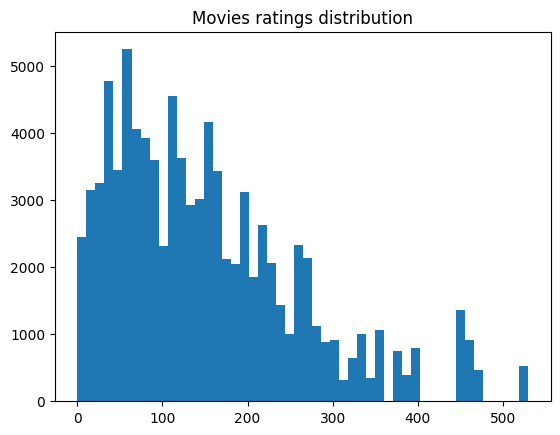

In [12]:
import matplotlib.pyplot as plt
plt.hist(rating_movies_df.total_rating_count, bins=50)
plt.title("Movies ratings distribution")
plt.show()

In [13]:
ratings_threshold = 100
rating_popular_movies_df = rating_movies_df.loc[rating_movies_df.total_rating_count >= ratings_threshold]
print(rating_popular_movies_df.shape)
rating_popular_movies_df.head()

(55524, 5)


,user_id,movie_id,rating,title,total_rating_count
109,1.0,178,5.0,12 Angry Men (1957),115
110,6.0,178,4.0,12 Angry Men (1957),115
111,7.0,178,4.0,12 Angry Men (1957),115
112,10.0,178,5.0,12 Angry Men (1957),115
113,13.0,178,4.0,12 Angry Men (1957),115


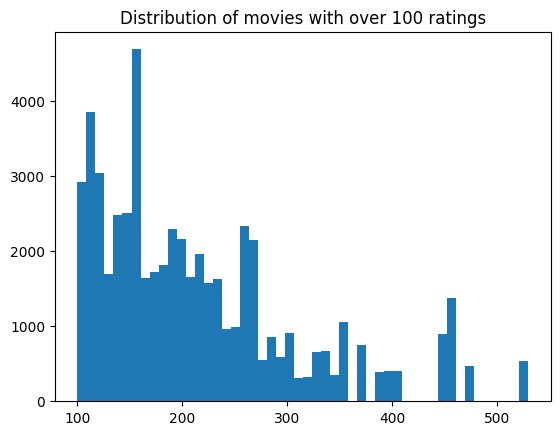

In [14]:
plt.hist(rating_popular_movies_df.total_rating_count, bins=50)
plt.title("Distribution of movies with over 100 ratings")
plt.show()

In [15]:
user_features_df = rating_popular_movies_df.pivot_table(index="user_id", columns="title", values="rating").fillna(0.0)

In [16]:
user_features_matrix = csr_matrix(user_features_df)

In [17]:
model_knn = NearestNeighbors(metric = "cosine", algorithm = "brute", n_neighbors = 20, n_jobs=-1)
model_knn.fit(user_features_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [18]:
user_features_df.shape

(938, 306)

In [19]:
user_features_df

title,12 Angry Men (1957),2001: A Space Odyssey (1968),Absolute Power (1997),"Abyss, The (1989)","African Queen, The (1951)",Air Force One (1997),Aladdin (1992),Alien (1979),Alien: Resurrection (1997),Aliens (1986),...,Volcano (1997),Wag the Dog (1997),Welcome to the Dollhouse (1995),What's Eating Gilbert Grape (1993),When Harry Met Sally... (1989),While You Were Sleeping (1995),Willy Wonka and the Chocolate Factory (1971),"Wizard of Oz, The (1939)","Wrong Trousers, The (1993)",Young Frankenstein (1974)
user_id,,,,,,,,,,,,,,,,,,,,,
1.0,5.0,4.0,0.0,3.0,0.0,0.0,4.0,5.0,0.0,5.0,...,0.0,0.0,5.0,4.0,5.0,4.0,4.0,4.0,5.0,5.0
2.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,3.0,...,0.0,0.0,0.0,0.0,1.0,1.0,3.0,0.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
test_df

,user_id,movie_id,rating
96581,820,347,4
91431,820,286,4
83459,820,333,5
58401,820,538,3
95404,820,302,5
...,...,...,...
85483,943,508,5
97674,943,763,4
96160,943,50,4
73242,943,412,2


In [21]:
query_index = np.random.choice(user_features_df.shape[0])
print(query_index)

501


In [22]:
distances, indices = model_knn.kneighbors(user_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

In [23]:
def recommend_with_similarity_weight(user_id=10, n_users=10, rec_top_n=20, min_rating=3.5):
    """
    Gợi ý phim dựa trên trọng số độ tương đồng giữa người dùng.
    """
    # Tìm n người dùng tương đồng nhất với user_id
    distances, indices = model_knn.kneighbors(
        user_features_df.loc[user_features_df.index == user_id].values.reshape(1, -1),
        n_neighbors=n_users + 1  # +1 để bao gồm cả người dùng hiện tại
    )

    # Lấy danh sách user_id và độ tương đồng tương ứng (bỏ người dùng hiện tại)
    user_ids = [user_features_df.index[indices.flatten()[i]] for i in range(1, n_users + 1)]
    similarities = 1 - distances.flatten()[1:]  # Độ tương đồng (1 - khoảng cách)

    # Lấy các đánh giá của người dùng tương đồng và lọc ra những phim có rating > min_rating
    sel_ratings = rating_popular_movies_df.loc[
        rating_popular_movies_df.user_id.isin(user_ids) & (rating_popular_movies_df.rating > min_rating)
    ]

    # Loại bỏ các phim đã được người dùng hiện tại xem
    movies_rated_by_targeted_user = rating_popular_movies_df.loc[
        rating_popular_movies_df.user_id == user_id, "movie_id"
    ].values
    sel_ratings = sel_ratings.loc[~sel_ratings.movie_id.isin(movies_rated_by_targeted_user)]

    # Tính avg score (trung bình có trọng số theo similarity) cho mỗi phim
    movie_scores = {}
    for movie_id in sel_ratings["movie_id"].unique():
        ratings_for_movie = sel_ratings[sel_ratings.movie_id == movie_id]

        # Tính tổng trọng số (numerator) và tổng similarity (denominator)
        numerator = 0
        denominator = 0
        for _, row in ratings_for_movie.iterrows():
            user_index = user_ids.index(row["user_id"])  # Vị trí người dùng trong danh sách
            sim = similarities[user_index]  # Độ tương đồng với người dùng hiện tại
            numerator += sim * row["rating"]
            denominator += sim

        # Tính avg score cho phim này
        movie_scores[int(movie_id)] = numerator / denominator if denominator != 0 else 0

    # Tính viewer score chuẩn hóa theo similarity (thang điểm 5)
    movie_priority = sel_ratings.groupby("movie_id").agg(
        viewers=("user_id", "nunique")  # Số lượng người dùng đã xem
    ).reset_index()
    movie_priority["viewer_score"] = (
        movie_priority["viewers"] / max(movie_priority["viewers"]) * 5
    )

    # Kết hợp avg score và viewer score để tính final score
    movie_priority["avg_score"] = movie_priority["movie_id"].map(movie_scores)
    movie_priority["final_score"] = (
        movie_priority["viewer_score"] * 0.51 + movie_priority["avg_score"] * 0.49
    )

    # Sắp xếp theo final_score giảm dần và lấy top n phim
    top_movies = movie_priority.sort_values(by="final_score", ascending=False).head(rec_top_n)

    # Trả ra danh sách list con chứa [movie_id, final_score]
    recommended_movie_ids = [[int(row.movie_id), row.final_score] for _, row in top_movies.iterrows()]
    return recommended_movie_ids

# Gọi hàm và in ra kết quả
recommended_ids = recommend_with_similarity_weight(user_id=12, n_users=10, rec_top_n=20)
print(recommended_ids)


[[423, 4.756600325889202], [496, 4.690127460548359], [181, 4.528748086799556], [210, 4.308421804007348], [385, 4.241003610371899], [64, 4.234999999999999], [173, 4.163635242240162], [1, 3.9526645857962306], [183, 3.952213597107396], [79, 3.8901637014633215], [12, 3.8880885906606877], [121, 3.88451623300421], [237, 3.817452725543227], [483, 3.816335274171374], [692, 3.8136452836607306], [275, 3.8124708964209844], [588, 3.7353756304923946], [22, 3.7296316771369975], [194, 3.6513961296128334], [117, 3.651218588906233]]


In [24]:
recommended_movies = recommend_with_similarity_weight(
    user_id=10, n_users=6, rec_top_n=10, min_rating=3
)
recommended_movie_ids = [movie[0] for movie in recommended_movies]  # Lấy danh sách movie_id
recommended_movie_ids

[427, 187, 318, 514, 209, 515, 89, 428, 213, 523]

In [25]:
user_id = 2
recommended_movies = recommend_with_similarity_weight(
    user_id=user_id, n_users=6, rec_top_n=10, min_rating=3
)
recommended_movie_ids = [movie[0] for movie in recommended_movies]  # Lấy danh sách movie_id
recommended_movie_ids
# Lấy danh sách phim thực tế có rating cao trong tập test
actual_movies = test_df.loc[
    (test_df['user_id'] == user_id) & (test_df['rating'] >= 3.0), 'movie_id'
].values
actual_movies
# Tính số lượng phim được gợi ý đúng
relevant_movies = set(recommended_movie_ids) & set(actual_movies)  # Giao giữa 2 danh sách
num_relevant = len(relevant_movies)

# Precision@K
precision_at_k = num_relevant / 10

# Recall@K
recall_at_k = num_relevant / len(actual_movies) if len(actual_movies) > 0 else 0
# Tính HR (Hit Ratio)
hit_ratio = 1 if len(relevant_movies) > 0 else 0

# Tính F1-Score
if precision_at_k + recall_at_k > 0:
    f1_score = 2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k)
else:
    f1_score = 0

# In kết quả
print(f"Hit Ratio (HR): {hit_ratio}")
print(f"F1-Score: {f1_score:.4f}")

# In kết quả
print(f"Precision@K: {precision_at_k:.4f}")
print(f"Recall@K: {recall_at_k:.4f}")


Hit Ratio (HR): 0
F1-Score: 0.0000
Precision@K: 0.0000
Recall@K: 0.0000


In [26]:
import numpy as np

def calculate_metrics(test_df, recommend_with_similarity_weight, n_users=6, rec_top_n=10, min_rating=3):
    all_hit_ratios = []
    all_ndcgs = []

    unique_users = test_df['user_id'].unique()  # Lấy danh sách user_id

    for user_id in unique_users:
        # Gợi ý phim cho người dùng
        recommended_movies = recommend_with_similarity_weight(
            user_id=user_id, n_users=n_users, rec_top_n=rec_top_n, min_rating=min_rating
        )
        recommended_movie_ids = [movie[0] for movie in recommended_movies]

        # Lấy danh sách phim thực tế có rating cao trong tập test
        actual_movies = test_df.loc[
            (test_df['user_id'] == user_id) & (test_df['rating'] >= min_rating), 'movie_id'
        ].values

        # Tính Hit Ratio
        relevant_movies = set(recommended_movie_ids) & set(actual_movies)
        hit_ratio = 1 if len(relevant_movies) > 0 else 0

        # Tính DCG (Discounted Cumulative Gain)
        dcg = 0
        for i, movie_id in enumerate(recommended_movie_ids):
            if movie_id in actual_movies:  # Phim được đánh giá cao có trong danh sách gợi ý
                dcg += 1 / np.log2(i + 2)  # Log2(i+2) để tránh chia cho 0 và đảm bảo thứ tự bắt đầu từ 1

        # Tính IDCG (Ideal DCG)
        ideal_dcg = sum(1 / np.log2(i + 2) for i in range(min(len(actual_movies), rec_top_n)))

        # Tính NDCG
        ndcg = dcg / ideal_dcg if ideal_dcg > 0 else 0

        # Lưu kết quả
        all_hit_ratios.append(hit_ratio)
        all_ndcgs.append(ndcg)

    # Tính trung bình HR và NDCG
    avg_hit_ratio = sum(all_hit_ratios) / len(all_hit_ratios)
    avg_ndcg = sum(all_ndcgs) / len(all_ndcgs)

    # Trả về kết quả
    return {
        "HR": avg_hit_ratio,
        "NDCG": avg_ndcg
    }


In [ ]:
metrics = calculate_metrics(test_df, recommend_with_similarity_weight, n_users=7, rec_top_n=10, min_rating=3)
metrics

In [259]:
0.08695652173913043 * 943 / 100

0.82

In [260]:
# metrics0 = calculate_metrics(test_df, recommend_with_similarity_weight, n_users=7, rec_top_n=10, min_rating=0)
# metrics1 = calculate_metrics(test_df, recommend_with_similarity_weight, n_users=7, rec_top_n=10, min_rating=1)
# metrics2 = calculate_metrics(test_df, recommend_with_similarity_weight, n_users=7, rec_top_n=10, min_rating=2)
# metrics3 = calculate_metrics(test_df, recommend_with_similarity_weight, n_users=7, rec_top_n=10, min_rating=3)
# metrics4 = calculate_metrics(test_df, recommend_with_similarity_weight, n_users=7, rec_top_n=10, min_rating=4)

# print("Min rating = 0:", metrics0)
# print("Min rating = 1:", metrics1)
# print("Min rating = 2:", metrics2)
# print("Min rating = 3:", metrics3)
# print("Min rating = 4:", metrics4)

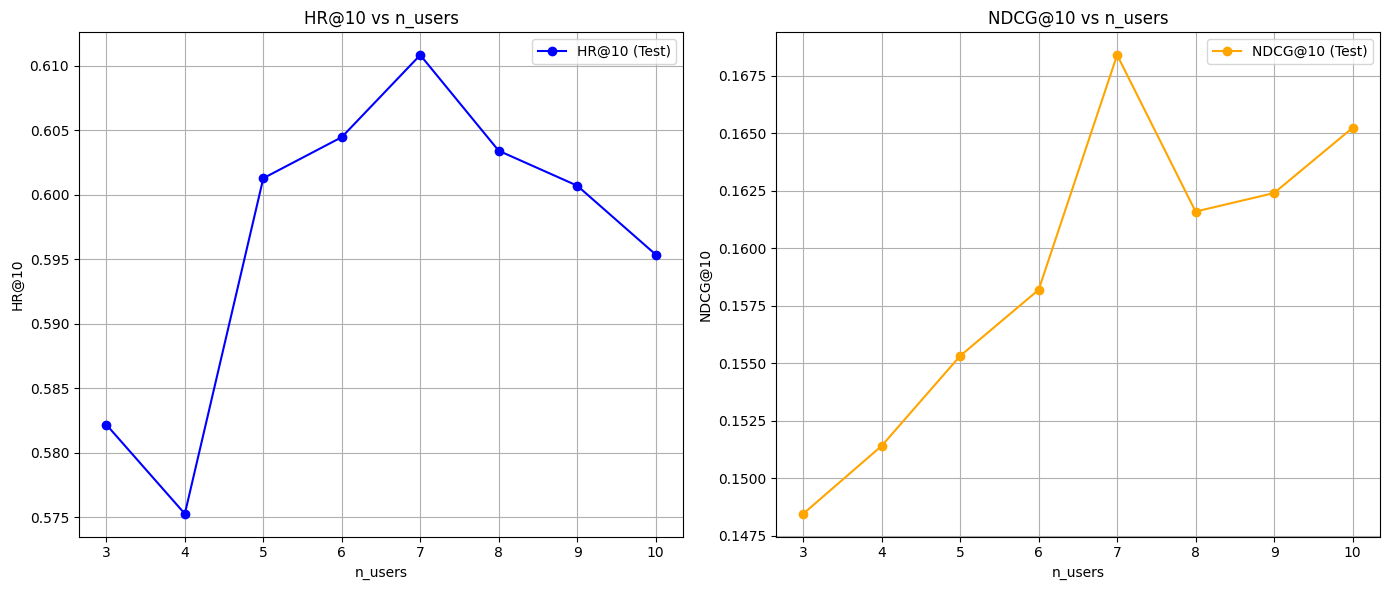

In [ ]:
import matplotlib.pyplot as plt

# Data
n_users = [3, 4, 5, 6, 7, 8, 9, 10]
HR_values = [0.5821845147973489, 0.5752814514797486, 0.601272354464475, 0.6044537850266828, 
             0.6108156429483287, 0.6033994252386002, 0.6006956521739131, 0.595362458192063]
NDCG_values = [0.14845631099748766, 0.15140975609981651, 0.15531804008894603, 0.1581909958759726, 
               0.168394839028567, 0.1615904931638643, 0.16239585063380293, 0.16522684519206297]

# Plot
plt.figure(figsize=(14, 6))

# HR plot
plt.subplot(1, 2, 1)
plt.plot(n_users, HR_values, marker='o', linestyle='-', color='blue', label='HR@10 (Test)')
plt.title('HR@10 vs n_users')
plt.xlabel('n_users')
plt.ylabel('HR@10')
plt.grid(True)
plt.legend()

# NDCG plot
plt.subplot(1, 2, 2)
plt.plot(n_users, NDCG_values, marker='o', linestyle='-', color='orange', label='NDCG@10 (Test)')
plt.title('NDCG@10 vs n_users')
plt.xlabel('n_users')
plt.ylabel('NDCG@10')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


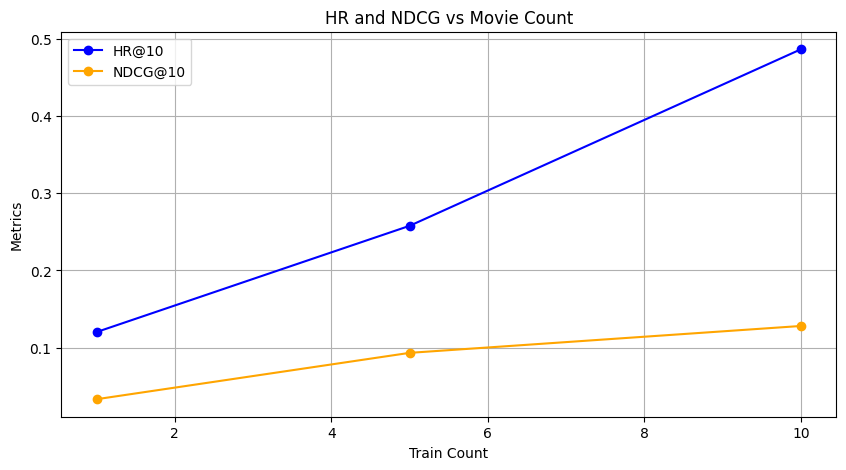

In [31]:
import matplotlib.pyplot as plt

# Dữ liệu HR và NDCG
train_counts = [1, 5, 10]
hr_values = [0.1203, 0.2578, 0.4863]
ndcg_values = [0.0334, 0.0934, 0.1282]

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
plt.plot(train_counts, hr_values, marker='o', label="HR@10", color='blue')
plt.plot(train_counts, ndcg_values, marker='o', label="NDCG@10", color='orange')

# Cài đặt trục và tiêu đề
plt.title("HR and NDCG vs Movie Count")
plt.xlabel("Train Count")
plt.ylabel("Metrics")
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()
